In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

get some basic info of data files

In [2]:
# ValueError: could not convert string to float: '8789-0'
def read_data_partial(given_fname, output_fname, lim=399999):
    content = []
    count = 1

    with open(given_fname, 'r') as fr:
        for line in fr:
            if count <= lim:
                #print(type(line), line)
                content.append(line)
                count += 1
    with open(output_fname, 'w') as fw:
        for line in content:
            # print(type(line), line)
            fw.write(line)
    
    data = pd.read_csv(output_fname, index_col=False)

    return data

## drop u, g, r bands

In [3]:
qso_train_partial = read_data_partial('quasar_train_catalog.csv', 'qso_train_partial.csv')
qso_train_drop = qso_train_partial[['z', 'r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_train_drop = qso_train_drop.replace(99.99, np.nan).dropna()
qso_train_drop = qso_train_drop[qso_train_drop['z'] < 7.5]
qso_train_drop = qso_train_drop[(qso_train_drop['r_LSST_magerr']>0.2)&(qso_train_drop['i_LSST_magerr']>0.2)]
redshifts26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 22.0]
redshifts26 = redshifts26[redshifts26['z_LSST_mag'] < 26.0]
redshifts26 = redshifts26['z']
qso_train_drop = qso_train_drop.drop(columns=['z', 'r_LSST_magerr', 'i_LSST_magerr'])
print('qso_train_catalog_z.csv partial data description: ')
qso_train_drop.describe()

qso_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000
mean,28.576193,26.616020,24.340320,24.201112,24.264969,24.132527
std,1.218340,1.654428,2.009015,2.089360,2.112093,2.108081
min,26.672280,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.689657,25.314514,23.136710,22.977195,23.069490,22.937156
50%,28.366448,26.540555,24.371926,24.306130,24.363508,24.192066
75%,29.189413,27.668971,25.789820,25.697926,25.766767,25.595761
max,38.902328,36.769079,32.115011,32.168396,32.742341,33.953075


(array([1986., 1725., 1511., 1102.,   95.,   74.,  366.,  489.,  380.,
         271.]),
 array([6.0001027 , 6.15004544, 6.29998818, 6.44993092, 6.59987366,
        6.7498164 , 6.89975914, 7.04970188, 7.19964462, 7.34958736,
        7.4995301 ]),
 <BarContainer object of 10 artists>)

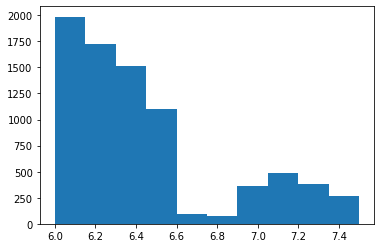

In [4]:
plt.hist(redshifts26)

In [5]:
# brown dwarf contaminants
mlt_train_partial = read_data_partial('mlt_train_catalog.csv', 'mlt_train_partial.csv', 599999)
mlt_train_drop = mlt_train_partial[['r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_train_drop = mlt_train_drop.replace(99.99, np.nan).dropna()
mlt_train_drop = mlt_train_drop[(mlt_train_drop['r_LSST_magerr']>0.2)&(mlt_train_drop['i_LSST_magerr']>0.2)]
mlt_train_drop = mlt_train_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('mlt_train_catalog_z.csv partial data description: ')
mlt_train_drop.describe()

mlt_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000
mean,27.846368,26.406966,24.814492,24.240174,23.941983,23.954949
std,0.866569,0.814599,0.652285,0.636041,0.633281,0.639802
min,26.565172,24.640153,22.966413,22.249321,21.884903,21.705643
25%,27.248302,25.848580,24.336131,23.782914,23.500752,23.511550
50%,27.631546,26.262440,24.722560,24.157117,23.877029,23.890512
75%,28.185010,26.792519,25.207176,24.619579,24.324040,24.337251
max,38.215437,36.198974,28.369839,27.735964,27.180561,27.305963


In [6]:
galaxies_patch8789_partial = read_data_partial('galaxies_train_catalog_patch8789.csv', 'galaxies_patch8789_partial.csv')
galaxies_patch8789_drop = galaxies_patch8789_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan).dropna()
galaxies_patch8789_drop = galaxies_patch8789_drop[(galaxies_patch8789_drop['r_LSST_magerr']>0.2)&(galaxies_patch8789_drop['i_LSST_magerr']>0.2)]
galaxies_patch8789_drop = galaxies_patch8789_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8789.csv partial data description: ')
galaxies_patch8789_drop.describe()

galaxies_train_catalog_patch8789.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000
mean,28.112741,27.507701,27.330679,27.226355,27.160891,27.154280
std,0.888656,0.950758,0.788433,0.796900,0.827853,0.977009
min,26.647539,25.462982,25.152190,24.748167,24.475726,24.258516
25%,27.518918,26.883531,26.837638,26.737179,26.657671,26.557470
50%,27.920273,27.314756,27.248012,27.172407,27.118375,27.041903
75%,28.465759,27.895376,27.710084,27.634895,27.594613,27.601858
max,40.029429,39.261958,39.647494,40.707497,38.204669,38.379259


In [7]:
galaxies_patch8786_partial = read_data_partial('galaxies_train_catalog_patch8786.csv', 'galaxies_patch8786_partial.csv')
galaxies_patch8786_drop = galaxies_patch8786_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan).dropna()
galaxies_patch8786_drop = galaxies_patch8786_drop[(galaxies_patch8786_drop['r_LSST_magerr']>0.2)&(galaxies_patch8786_drop['i_LSST_magerr']>0.2)]
galaxies_patch8786_drop = galaxies_patch8786_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8786.csv partial data description: ')
galaxies_patch8786_drop.describe()

galaxies_train_catalog_patch8786.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000
mean,28.100839,27.494196,27.312890,27.205311,27.141593,27.131091
std,0.886168,0.952284,0.787836,0.803832,0.842035,0.981601
min,26.573603,25.553776,25.107279,24.705397,24.460871,24.280885
25%,27.507428,26.871497,26.818026,26.714657,26.633417,26.535331
50%,27.905549,27.298753,27.235470,27.156032,27.102195,27.024873
75%,28.452895,27.883019,27.697073,27.620384,27.584425,27.588162
max,40.812877,40.422024,37.436853,38.037623,37.411129,37.630643


### drop missing values

In [8]:
print(qso_train_drop.head(), len(qso_train_drop))
print(np.where(np.isnan(qso_train_drop)))
print(len(mlt_train_drop))
print(np.where(np.isnan(mlt_train_drop)))
print(len(galaxies_patch8789_drop))
print(np.where(np.isnan(galaxies_patch8789_drop)))
print(len(galaxies_patch8786_drop))
print(np.where(np.isnan(galaxies_patch8786_drop)))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758 20759
(array([], dtype=int64), array([], dtype=int64))
40214
(array([], dtype=int64), array([], dtype=int64))
166180
(array([], dtype=int64), array([], dtype=int64))
156946
(array([], dtype=int64), array([], dtype=int64))


In [9]:
qso_train_drop['label'] = np.ones(len(qso_train_drop))
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))

### check the cleaned datasets and concatenate into new ones

In [10]:
print('qso:\n', qso_train_drop.head())
print('bd:\n', mlt_train_drop.head())
print('galaxies patch8789:\n', galaxies_patch8789_drop.head())
print('galaxies path8786:\n', galaxies_patch8786_drop.head())

qso:
       i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461   
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975   
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953   
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836   
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   

      label  
1281    1.0  
1307    1.0  
1329    1.0  
1344    1.0  
1350    1.0  
bd:
         i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
398247   26.888214   24.767034  24.160454  23.807130  23.455427  23.446447   
398253   26.758145   25.077703  24.012978  23.724390  23.529321  23.489750   
398350   26.817520   25.070334  24.192246  23.774151  23.644759  23.551041   
398458   26.976849   25.348521  24.372349  23.913859  23.949639  23.681874   
398464   26.788703   25.283402  24.121468  23.827350  23.8

In [11]:
# data concatenation to get training data
contaminants_drop = pd.concat([mlt_train_drop, galaxies_patch8789_drop, galaxies_patch8786_drop], ignore_index=True)
data_train_drop = pd.concat([qso_train_drop, contaminants_drop], ignore_index=True) # make sure that the data line up
X_drop = data_train_drop[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop = data_train_drop['label']

In [12]:
print(len(X_drop))

384099


In [13]:
X_drop.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000
mean,28.105037,27.338747,26.898356,26.741610,26.659483,26.646531
std,0.916743,1.058480,1.320838,1.417921,1.468364,1.548313
min,26.565172,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.487583,26.729171,26.520257,26.375729,26.271044,26.171445
50%,27.903062,27.208934,27.103179,27.019502,26.959260,26.869193
75%,28.471100,27.809780,27.602659,27.530272,27.490765,27.470353
max,40.812877,40.422024,39.647494,40.707497,38.204669,38.379259


## 24.0 < z < 26

In [14]:
qso_train_26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 24.0]
qso_train_26 = qso_train_26[qso_train_26['z_LSST_mag'] < 26.0]
print(len(qso_train_26))
mlt_train_26 = mlt_train_drop[mlt_train_drop['z_LSST_mag'] > 24.0]
mlt_train_26 = mlt_train_26[mlt_train_26['z_LSST_mag'] < 26.0]
print(len(mlt_train_26))
galaxies_patch8789_26 = galaxies_patch8789_drop[galaxies_patch8789_drop['z_LSST_mag'] > 24.0]
galaxies_patch8789_26 = galaxies_patch8789_26[galaxies_patch8789_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8789_26))
galaxies_patch8786_26 = galaxies_patch8786_drop[galaxies_patch8786_drop['z_LSST_mag'] > 24.0]
galaxies_patch8786_26 = galaxies_patch8786_26[galaxies_patch8786_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8786_26))

7514
13790
778
753


In [15]:
contaminants_26 = pd.concat([mlt_train_26, galaxies_patch8789_26, galaxies_patch8786_26], ignore_index=True)
data_train_26 = pd.concat([qso_train_26, contaminants_26], ignore_index=True)
X_drop_26 = data_train_26[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop_26 = data_train_26['label']

In [16]:
col_names = ['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X_drop_26[col] = X_drop_26[col_names[i]] - X_drop_26[col_names[j]]

X_drop_26_copy = X_drop_26.drop(columns=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'])

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


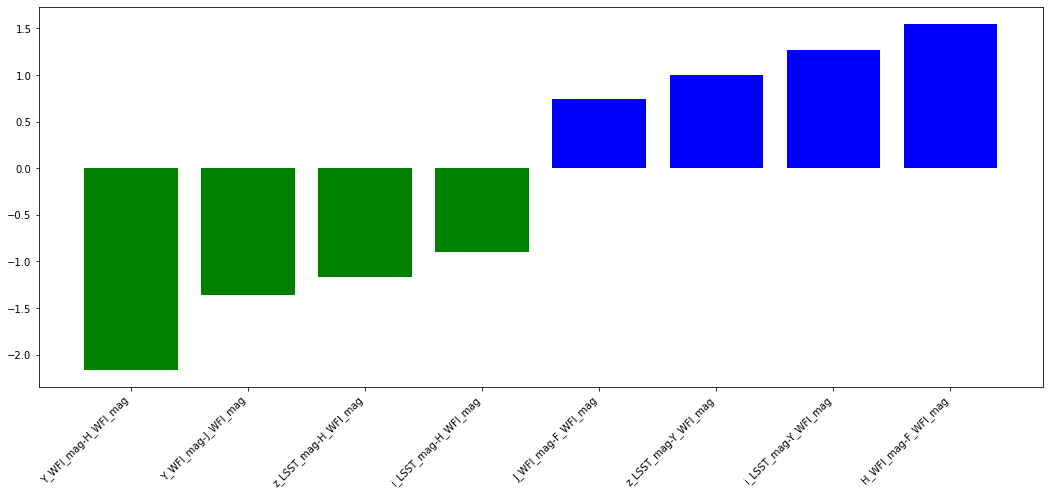

In [17]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X_drop_26_copy, Y_drop_26)
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X_drop_26_copy.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

In [17]:
# keep the columns with the highest influences & check if the dataframes look reasonable
X_drop_26 = X_drop_26[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-J_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'i_LSST_mag-H_WFI_mag', 'J_WFI_mag-F_WFI_mag', 'z_LSST_mag-Y_WFI_mag', 'i_LSST_mag-Y_WFI_mag', 'H_WFI_mag-F_WFI_mag', 'J_WFI_mag-H_WFI_mag']]

print(type(X_drop_26))
print('X with 24.0 < z < 26.0: \n', X_drop_26.head())

<class 'pandas.core.frame.DataFrame'>
X with 24.0 < z < 26.0: 
    i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   
1   27.524243   24.064202  18.581391  18.063651  17.962036  17.889791   
2   26.956233   24.175056  18.643111  18.057271  17.947544  17.923464   
3   27.085317   24.577786  18.568934  18.003694  17.874231  17.815912   
4   27.750373   24.204321  18.623443  18.056759  17.942237  17.873085   

   Y_WFI_mag-H_WFI_mag  Y_WFI_mag-J_WFI_mag  z_LSST_mag-H_WFI_mag  \
0             0.603390             0.515099              6.022002   
1             0.619356             0.517740              6.102166   
2             0.695568             0.585840              6.227512   
3             0.694703             0.565240              6.703555   
4             0.681206             0.566684              6.262084   

   i_LSST_mag-H_WFI_mag  J_WFI_mag-F_WFI_mag  z_LSST_mag-Y_WFI_mag  \
0           

In [18]:
X_drop_26_copy = X_drop_26.copy()

In [19]:
print(len(X_drop_26_copy))

22835


### KNN

In [29]:
def get_color_filter(clf, n_neighbors, weights, x1, x2, y1, y2, y):
    # Create color maps
    cmap_light = ListedColormap(['#75aff9', '#f7a844']) # blue, orange
    cmap_bold = ListedColormap(['#8dbcf9', '#f5a844']) 
    
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()

    # we create an instance of Neighbours Classifier and fit the data.
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = min(x1 - x2) - 1, max(x1 - x2) + 1
    y_min, y_max = min(y1 - y2) - 1, max(y1 - y2) + 1
    h = (x_max-x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.title("k = %i, weights = '%s'"
              % (n_neighbors, weights))

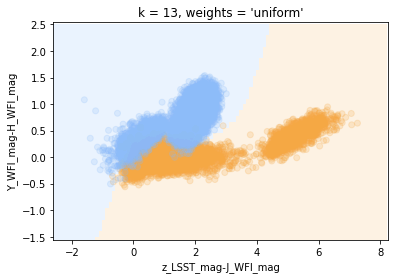

In [32]:
filter1a = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=13, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1a, 13, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['J_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-J_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

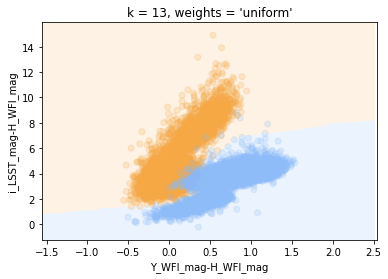

In [33]:
# x: Y - H 
# y: i - H
# best score:  0.9938063063063063
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 5, 'weights': 'uniform'}
# knn_training(X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [13, 19, 26, 30, 36, 40], [3, 5])

filter1b = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=13, leaf_size=3, weights='uniform', p=5)
get_color_filter(filter1b, 13, 'uniform', X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('Y_WFI_mag-H_WFI_mag')
plt.ylabel('i_LSST_mag-H_WFI_mag')
plt.show()

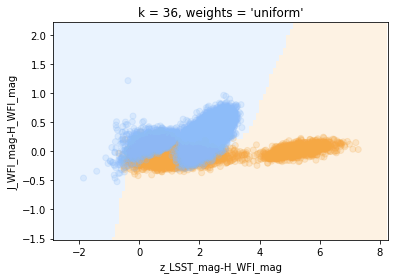

In [34]:
# x: z - H
# y: J - H
# best score:  0.9441316316316316
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 36, 'p': 5, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [19, 26, 30, 36, 42, 48], [3, 5])

filter1c = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=36, leaf_size=3, weights='uniform', p=5)
get_color_filter(filter1c, 36, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-H_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

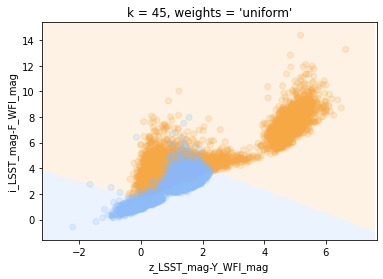

In [35]:
filter1d = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=45, leaf_size=3, weights='uniform', p=5)
get_color_filter(filter1d, 45, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-F_WFI_mag')
plt.show()

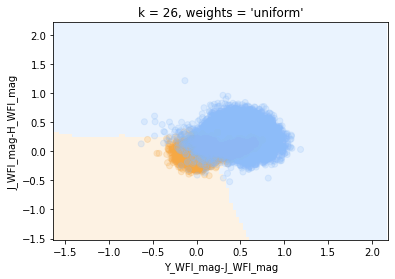

In [36]:
filter1e = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=26, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1e, 26, 'uniform', X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('Y_WFI_mag-J_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

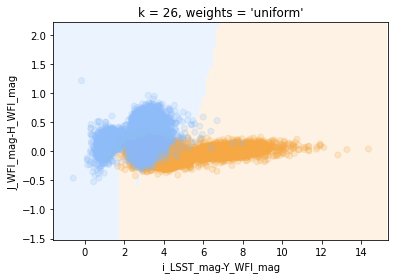

In [37]:
# x: i - Y
# y: J - H
# best score:  0.9161036036036035
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 26, 'p': 3, 'weights': 'uniform'}
# knn_training(X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [13, 17, 19, 26, 30, 36, 40], [3, 5])

filter1f = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=26, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1f, 26, 'uniform', X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('i_LSST_mag-Y_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

## Test

In [38]:
# retrieve redshift for later usage
qso_test = pd.read_csv('quasar_test_catalog.csv', index_col=False)
qso_test = qso_test[['z', 'r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test = qso_test.replace(99.99, np.nan).dropna()
qso_test = qso_test[(qso_test['r_LSST_magerr']>0.2)&(qso_test['i_LSST_magerr']>0.2)]
qso_test = qso_test.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
# qso_test = qso_test[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000
mean,6.334597,28.835404,26.798711,25.931247,25.903342,25.938094,25.724927
std,0.310122,1.238984,1.679970,1.773994,1.803031,1.796843,1.760516
min,6.000191,26.618546,23.163809,20.452226,20.223916,20.227606,20.164541
25%,6.104868,27.976921,25.507942,24.531768,24.504636,24.559612,24.386106
50%,6.244405,28.662272,26.856947,25.846617,25.823882,25.846930,25.666564
75%,6.469143,29.429633,27.855877,27.204031,27.190811,27.212475,26.946348
max,8.482816,35.495708,36.798806,35.672331,33.879891,34.514265,34.228085


In [39]:
galaxies_patch8788 = read_data_partial('galaxies_train_catalog_patch8788.csv', 'galaxies_patch8788_245.csv', 30000)
galaxies_patch8788 = galaxies_patch8788.replace(99.99, np.nan).dropna()
galaxies_patch8788 = galaxies_patch8788[['z', 'r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8788_26 = galaxies_patch8788[(galaxies_patch8788['r_LSST_magerr']>0.2)&(galaxies_patch8788['i_LSST_magerr']>0.2)]
galaxies_patch8788_26 = galaxies_patch8788.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8788.csv data description: ')
galaxies_patch8788.describe()

galaxies_train_catalog_patch8788.csv data description: 


,z,r_LSST_magerr,i_LSST_magerr,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000
mean,1.032609,0.071881,0.074232,25.064565,24.472561,24.263562,24.133942,24.032490,23.970953
std,0.014266,0.336052,0.207255,1.258280,1.250795,1.294158,1.348217,1.403003,1.451221
min,1.005989,0.010337,0.010588,20.738443,20.199310,19.730171,19.315425,18.971169,18.750817
25%,1.020363,0.025039,0.027430,24.321473,23.749411,23.524088,23.357096,23.211484,23.120767
50%,1.033982,0.045740,0.049470,25.208614,24.607205,24.439207,24.332423,24.249539,24.205313
75%,1.045150,0.079893,0.086826,25.930392,25.342387,25.182842,25.094375,25.045359,25.005333
max,1.055212,43.286299,23.300493,32.004925,31.083271,28.285061,28.161714,30.885336,32.729688


In [40]:
mlt_test = read_data_partial('mlt_test_catalog_z.csv', 'mlt_test_catalog_z26.csv', 120000)
mlt_test = mlt_test[['spt', 'r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_test = mlt_test.replace(99.99, np.nan).dropna()
mlt_test = mlt_test[(mlt_test['r_LSST_magerr']>0.2)&(mlt_test['i_LSST_magerr']>0.2)]
mlt_test = mlt_test.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
mlt_test['z'] = np.zeros(mlt_test.shape[0])
print('mlt_test_catalog partial data description: ')
mlt_test.describe()

mlt_test_catalog partial data description: 


,spt,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,z
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.0
mean,13.067001,27.294287,25.684152,24.222748,23.659324,23.357716,23.372401,0.0
std,2.983720,0.388016,0.231342,0.295505,0.317678,0.377004,0.388734,0.0
min,7.000000,26.601001,24.571247,22.301314,22.013013,21.873094,21.742619,0.0
25%,11.000000,27.036202,25.538164,24.027244,23.452812,23.114613,23.130337,0.0
50%,13.000000,27.206518,25.726646,24.225623,23.658451,23.360445,23.377344,0.0
75%,15.000000,27.458651,25.871890,24.418692,23.872214,23.612628,23.627727,0.0
max,29.000000,32.622297,25.999972,25.767020,25.011076,24.808649,25.154299,0.0


In [41]:
qso_test_copy = qso_test.copy()
qso_test_copy['label'] = np.ones(len(qso_test_copy))
qso_test_copy['spt'] = np.zeros(len(qso_test_copy))
galaxies_patch8788_copy = galaxies_patch8788.copy()
galaxies_patch8788_copy['label'] = np.zeros(len(galaxies_patch8788_copy))
galaxies_patch8788_copy['spt'] = np.zeros(len(galaxies_patch8788_copy))

In [42]:
mlt_test_copy = mlt_test.copy()
mlt_test_copy['label'] = np.zeros(len(mlt_test_copy))
mlt_test_26 = mlt_test[(mlt_test['z_LSST_mag']>24.0)&(mlt_test['z_LSST_mag']<26.0)]
test0 = pd.concat([qso_test_copy, galaxies_patch8788_copy, mlt_test_copy], ignore_index=True).drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
test = test0[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'label']]
test.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000
mean,26.330656,25.189267,24.420450,24.131116,23.965228,23.917886,0.103681
std,1.684789,1.313506,1.211908,1.305913,1.390285,1.377839,0.304850
min,20.738443,20.199310,19.730171,19.315425,18.971169,18.750817,0.000000
25%,25.199695,24.538908,23.929998,23.468960,23.182110,23.174899,0.000000
50%,26.869211,25.478009,24.318858,23.886534,23.682393,23.670638,0.000000
75%,27.317233,25.843108,24.892854,24.774591,24.718586,24.663740,0.000000
max,35.495708,36.798806,35.672331,33.879891,34.514265,34.228085,1.000000


In [43]:
qso_test_26 = qso_test[qso_test['z_LSST_mag'] < 26.0]
qso_test_26 = qso_test_26[qso_test_26['z_LSST_mag'] > 24.0]
qso_test_26_copy = qso_test_26.copy()
print('length of qso test catalog with 24 < z < 26:', len(qso_test_26))

length of qso test catalog with 24 < z < 26: 1344


### test individual filter:

In [49]:
test_copya = test.copy().drop(columns=['label'])
test_copya = test_copya[test_copya['z_LSST_mag'] > 24.0]
test_copya = test_copya[test_copya['z_LSST_mag'] < 26.0]
print(len(test_copya))

29983


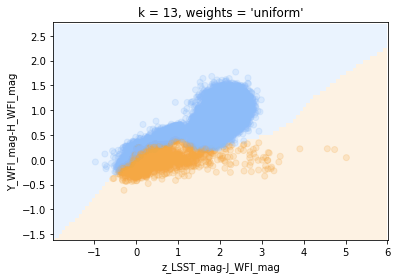

8584


In [51]:
# x: z - J
# y: Y - H
features1a = [X_drop_26['z_LSST_mag']-X_drop_26['J_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag']]
X1a = np.array(features1a).transpose()
filter1a.fit(X1a, Y_drop_26)
labelsa = filter1a.predict(np.array([test_copya['z_LSST_mag']-test_copya['J_WFI_mag'], test_copya['Y_WFI_mag']-test_copya['H_WFI_mag']]).transpose())

get_color_filter(filter1a, 13, 'uniform', test_copya['z_LSST_mag'], test_copya['J_WFI_mag'], test_copya['Y_WFI_mag'], test_copya['H_WFI_mag'], labelsa)
plt.xlabel('z_LSST_mag-J_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

test_copya['labela'] = labelsa
test_copya = test_copya[test_copya['labela'] == 1]
print(len(test_copya))

In [52]:
print(test_copya.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.145200   24.595492  23.955002  23.879654  23.708573  23.422524   
4      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
...          ...         ...        ...        ...        ...        ...   
1304   28.174040   24.392064  23.948284  23.908674  23.905087  23.667442   
1305   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1306   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1307   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1308   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      labela         z  
0        1.0  6.406638  
1        1.0  6.199295  
2        1.0

In [53]:
print('filter 1a (Y-H vs z-J) test precision:', round(len(test_copya.merge(qso_test_26))/len(test_copya), 4))
print('filter 1a (Y-H vs z-J) test recall:', round(len(test_copya.merge(qso_test_26))/len(qso_test_26), 4))

filter 1a (Y-H vs z-J) test precision: 0.1525
filter 1a (Y-H vs z-J) test recall: 0.974


In [56]:
test_copyb = test.copy().drop(columns=['label'])
test_copyb = test_copyb[test_copyb['z_LSST_mag'] > 24.0]
test_copyb = test_copyb[test_copyb['z_LSST_mag'] < 26.0]
print(len(test_copyb))

29983


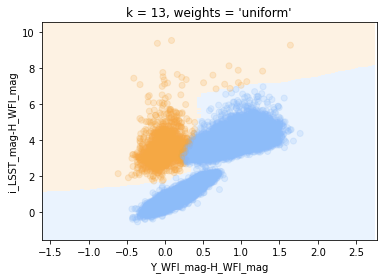

1448


In [57]:
# x: Y - H 
# y: i - H
features1b = [X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['H_WFI_mag']]
X1b = np.array(features1b).transpose()
filter1b.fit(X1b, Y_drop_26)
labelsb = filter1b.predict(np.array([test_copyb['Y_WFI_mag']-test_copyb['H_WFI_mag'], test_copyb['i_LSST_mag']-test_copyb['H_WFI_mag']]).transpose())

get_color_filter(filter1b, 13, 'uniform', test_copyb['Y_WFI_mag'], test_copyb['H_WFI_mag'], test_copyb['i_LSST_mag'], test_copyb['H_WFI_mag'], labelsb)
plt.xlabel('Y_WFI_mag-H_WFI_mag')
plt.ylabel('i_LSST_mag-H_WFI_mag')
plt.show()

test_copyb['labelb'] = labelsb
test_copyb = test_copyb[test_copyb['labelb'] == 1]
print(len(test_copyb))

In [58]:
print(test_copyb.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.145200   24.595492  23.955002  23.879654  23.708573  23.422524   
4      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
...          ...         ...        ...        ...        ...        ...   
1323   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1324   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1325   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1326   27.890372   25.726710  25.898793  26.122272  25.949780  25.798436   
1327   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      labelb         z  
0        1.0  6.406638  
1        1.0  6.199295  
2        1.0

In [60]:
print('filter 1b (i-H vs Y-H) test precision:', round(len(test_copyb.merge(qso_test_26))/len(test_copyb), 4))
print('filter 1b (i-H vs Y-H) test recall:', round(len(test_copyb.merge(qso_test_26))/len(qso_test_26), 4))

filter 1b (i-H vs Y-H) test precision: 0.9171
filter 1b (i-H vs Y-H) test recall: 0.9881


In [61]:
test_copyc = test.copy().drop(columns=['label'])
test_copyc = test_copyc[test_copyc['z_LSST_mag'] > 24.0]
test_copyc = test_copyc[test_copyc['z_LSST_mag'] < 26.0]
print(len(test_copyc))

29983


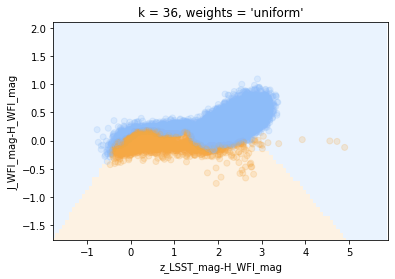

10810


In [62]:
# x: z - H
# y: J - H
features1c = [X_drop_26['z_LSST_mag']-X_drop_26['H_WFI_mag'], X_drop_26['J_WFI_mag']-X_drop_26['H_WFI_mag']]
X1c = np.array(features1c).transpose()
filter1c.fit(X1c, Y_drop_26)
labelsc = filter1c.predict(np.array([test_copyc['z_LSST_mag']-test_copyc['H_WFI_mag'], test_copyc['J_WFI_mag']-test_copyc['H_WFI_mag']]).transpose())

get_color_filter(filter1c, 36, 'uniform', test_copyc['z_LSST_mag'], test_copyc['H_WFI_mag'], test_copyc['J_WFI_mag'], test_copyc['H_WFI_mag'], labelsc)
plt.xlabel('z_LSST_mag-H_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

test_copyc['labelc'] = labelsc
test_copyc = test_copyc[test_copyc['labelc'] == 1]
print(len(test_copyc))

In [63]:
print(test_copyc.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
4      29.509331   25.131273  24.335726  24.336202  24.479644  24.385943   
...          ...         ...        ...        ...        ...        ...   
1202   28.826054   25.717920  24.576910  24.291420  24.313495  24.151953   
1203   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1204   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1205   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1206   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      labelc         z  
0        1.0  6.406638  
1        1.0  6.199295  
2        1.0

In [65]:
print('filter 1c (J-H vs z-H) test precision:', round(len(test_copyc.merge(qso_test_26))/len(test_copyc), 4))
print('filter 1c (J-H vs z-H) test recall:', round(len(test_copyc.merge(qso_test_26))/len(qso_test_26), 4))

filter 1c (J-H vs z-H) test precision: 0.1117
filter 1c (J-H vs z-H) test recall: 0.8981


In [66]:
test_copyd = test.copy().drop(columns=['label'])
test_copyd = test_copyd[test_copyd['z_LSST_mag'] > 24.0]
test_copyd = test_copyd[test_copyd['z_LSST_mag'] < 26.0]
print(len(test_copyd))

29983


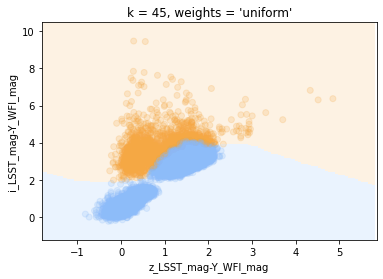

1775


In [67]:
# x: z - Y
# y: i - Y
features1d = [X_drop_26['z_LSST_mag']-X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag']]
X1d = np.array(features1d).transpose()
filter1d.fit(X1d, Y_drop_26)
labelsd = filter1d.predict(np.array([test_copyd['z_LSST_mag']-test_copyd['Y_WFI_mag'], test_copyd['i_LSST_mag']-test_copyd['Y_WFI_mag']]).transpose())

get_color_filter(filter1d, 45, 'uniform', test_copyd['z_LSST_mag'], test_copyd['Y_WFI_mag'], test_copyd['i_LSST_mag'], test_copyd['Y_WFI_mag'], labelsd)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

test_copyd['labeld'] = labelsd
test_copyd = test_copyd[test_copyd['labeld'] == 1]
print(len(test_copyd))

In [68]:
print(test_copyd.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.145200   24.595492  23.955002  23.879654  23.708573  23.422524   
4      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
...          ...         ...        ...        ...        ...        ...   
1270   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1271   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1272   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1273   27.890372   25.726710  25.898793  26.122272  25.949780  25.798436   
1274   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      labeld         z  
0        1.0  6.406638  
1        1.0  6.199295  
2        1.0

In [69]:
print('filter 1d (i-Y vs z-Y) test precision:', round(len(test_copyd.merge(qso_test_26))/len(test_copyd), 4))
print('filter 1d (i-Y vs z-Y) test recall:', round(len(test_copyd.merge(qso_test_26))/len(qso_test_26), 4))

filter 1d (i-Y vs z-Y) test precision: 0.7183
filter 1d (i-Y vs z-Y) test recall: 0.9487


In [70]:
test_copye = test.copy().drop(columns=['label'])
test_copye = test_copye[test_copye['z_LSST_mag'] > 24.0]
test_copye = test_copye[test_copye['z_LSST_mag'] < 26.0]
print(len(test_copye))

29983


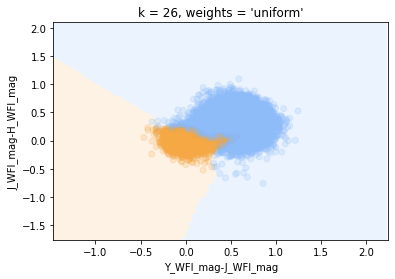

11011


In [71]:
features1e = [X_drop_26['Y_WFI_mag']-X_drop_26['J_WFI_mag'], X_drop_26['J_WFI_mag']-X_drop_26['H_WFI_mag']]
X1e = np.array(features1e).transpose()
filter1e.fit(X1e, Y_drop_26)
labelse = filter1e.predict(np.array([test_copye['Y_WFI_mag']-test_copye['J_WFI_mag'], test_copye['J_WFI_mag']-test_copye['H_WFI_mag']]).transpose())

get_color_filter(filter1e, 26, 'uniform', test_copye['Y_WFI_mag'], test_copye['J_WFI_mag'], test_copye['J_WFI_mag'], test_copye['H_WFI_mag'], labelse)
plt.xlabel('Y_WFI_mag-J_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

test_copye['labele'] = labelse
test_copye = test_copye[test_copye['labele'] == 1]
print(len(test_copye))

In [72]:
print(test_copye.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.145200   24.595492  23.955002  23.879654  23.708573  23.422524   
4      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
...          ...         ...        ...        ...        ...        ...   
1310   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1311   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1312   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1313   27.890372   25.726710  25.898793  26.122272  25.949780  25.798436   
1314   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      labele         z  
0        1.0  6.406638  
1        1.0  6.199295  
2        1.0

In [73]:
print('filter 1e (J-H vs Y-J) test precision:', round(len(test_copye.merge(qso_test_26))/len(test_copye), 4))
print('filter 1e (J-H vs Y-J) test recall:', round(len(test_copye.merge(qso_test_26))/len(qso_test_26), 4))

filter 1e (J-H vs Y-J) test precision: 0.1194
filter 1e (J-H vs Y-J) test recall: 0.9784


In [74]:
test_copyf = test.copy().drop(columns=['label'])
test_copyf = test_copyf[test_copyf['z_LSST_mag'] > 24.0]
test_copyf = test_copyf[test_copyf['z_LSST_mag'] < 26.0]
print(len(test_copyf))

29983


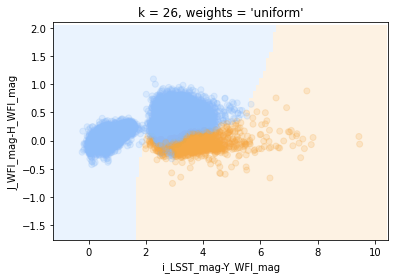

1900


In [75]:
# x: i - Y
# y: J - H
features1f = [X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag']-X_drop_26['H_WFI_mag']]
X1f = np.array(features1f).transpose()
filter1f.fit(X1f, Y_drop_26)
labelsf = filter1f.predict(np.array([test_copyf['i_LSST_mag']-test_copyf['Y_WFI_mag'], test_copyf['J_WFI_mag']-test_copyf['H_WFI_mag']]).transpose())

get_color_filter(filter1f, 26, 'uniform', test_copyf['i_LSST_mag'], test_copyf['Y_WFI_mag'], test_copyf['J_WFI_mag'], test_copyf['H_WFI_mag'], labelsf)
plt.xlabel('i_LSST_mag-Y_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

test_copyf['labelf'] = labelsf
test_copyf = test_copyf[test_copyf['labelf'] == 1]
print(len(test_copyf))

In [76]:
print(test_copyf.merge(qso_test_26))

     i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0     27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1     27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
2     29.509331   25.131273  24.335726  24.336202  24.479644  24.385943   
3     27.159156   24.125266  23.680375  23.751224  23.761836  23.513345   
4     26.955239   24.624662  23.100171  22.924883  22.912477  22.686470   
..          ...         ...        ...        ...        ...        ...   
990   28.826054   25.717920  24.576910  24.291420  24.313495  24.151953   
991   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
992   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
993   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
994   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

     labelf         z  
0       1.0  6.406638  
1       1.0  6.281061  
2       1.0  6.423103  
3  

In [77]:
print('filter 1f (J-H vs i-Y) test precision:', round(len(test_copyf.merge(qso_test_26))/len(test_copyf), 4))
print('filter 1f (J-H vs i-Y) test recall:', round(len(test_copyf.merge(qso_test_26))/len(qso_test_26), 4))

filter 1f (J-H vs i-Y) test precision: 0.5237
filter 1f (J-H vs i-Y) test recall: 0.7403


### test weighted

In [78]:
test_copy = test.copy().drop(columns=['label'])
test_copy = test_copy[test_copy['z_LSST_mag'] > 24.0]
test_copy = test_copy[test_copy['z_LSST_mag'] < 26.0]

In [79]:
# x: z - J
# y: Y - H
testf_1a = [test_copy['z_LSST_mag']-test_copy['J_WFI_mag'], test_copy['Y_WFI_mag']-test_copy['H_WFI_mag']]
prob_1a = filter1a.predict_proba(np.array(testf_1a).transpose())
print('prediction okay')
# prob_1a: [prob of negative class, prob of positive class]
test_copy['prob_1a'] = prob_1a[:, 1]

prediction okay


In [80]:
# x: Y - H 
# y: i - H

prob_1b = filter1b.predict_proba(np.array([test_copy['Y_WFI_mag']-test_copy['H_WFI_mag'], test_copy['i_LSST_mag']-test_copy['H_WFI_mag']]).transpose())

test_copy['prob_1b'] = prob_1b[:, 1]

In [81]:
# x: z - H
# y: J - H

prob_1c = filter1c.predict_proba(np.array([test_copy['z_LSST_mag']-test_copy['H_WFI_mag'], test_copy['J_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

test_copy['prob_1c'] = prob_1c[:, 1]

In [82]:
# x: z - Y
# y: i - Y

prob_1d = filter1d.predict_proba(np.array([test_copy['z_LSST_mag']-test_copy['Y_WFI_mag'], test_copy['i_LSST_mag']-test_copy['Y_WFI_mag']]).transpose())

test_copy['prob_1d'] = prob_1d[:, 1]

In [83]:
# x: Y - J
# y: J - H

prob_1e = filter1e.predict_proba(np.array([test_copy['Y_WFI_mag']-test_copy['J_WFI_mag'], test_copy['J_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

test_copy['prob_1e'] = prob_1e[:, 1]

In [84]:
# x: i - Y
# y: J - H

prob_1f = filter1f.predict_proba(np.array([test_copy['i_LSST_mag']-test_copy['Y_WFI_mag'], test_copy['J_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

test_copy['prob_1f'] = prob_1f[:, 1]

In [86]:
# use best scores as weights:
weights = [0.9882 *1.1, 0.9938*(1-1/6), 0.9463, 0.9678 *(1+1/6), 0.95*(1+1/6), 0.9161]
probabilities = test_copy[['prob_1a', 'prob_1b', 'prob_1c', 'prob_1d', 'prob_1e', 'prob_1f']]
cols = ['prob_1a', 'prob_1b', 'prob_1c', 'prob_1d', 'prob_1e', 'prob_1f']

wprob = np.zeros(len(probabilities['prob_1a']))
for i in range(len(weights)):
    sum_weights = sum(weights)
    wprob += weights[i]*probabilities[cols[i]]/sum_weights

print(wprob.shape)

(29983,)


In [87]:
test_copy['weighted prob'] = wprob
test_copy.head()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,prob_1a,prob_1b,prob_1c,prob_1d,prob_1e,prob_1f,weighted prob
2,27.532037,25.116377,24.159598,24.087764,24.303871,24.112669,1.0,1.000000,1.0,0.733333,1.0,1.000000,0.949943
6,28.380834,25.834655,25.398672,25.600155,25.617763,25.537893,1.0,1.000000,1.0,1.000000,1.0,0.538462,0.929707
9,27.297134,24.478555,23.856727,23.854241,23.983015,23.734303,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000
12,27.145200,24.595492,23.955002,23.879654,23.708573,23.422524,1.0,0.538462,0.0,1.000000,1.0,0.000000,0.626829
15,27.109296,24.386038,24.050289,24.216277,24.179047,23.936038,1.0,1.000000,1.0,1.000000,1.0,0.000000,0.847698


In [88]:
pred_qso = test_copy[test_copy['weighted prob'] > 0.6]
pred_qso.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,prob_1a,prob_1b,prob_1c,prob_1d,prob_1e,prob_1f,weighted prob
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000
mean,28.073432,25.067229,24.455755,24.449789,24.484995,24.300053,0.982785,0.992565,0.906340,0.925138,0.986017,0.758393,0.927704
std,0.934696,0.557408,0.705205,0.756190,0.738461,0.720290,0.114766,0.057594,0.255351,0.239564,0.095633,0.383277,0.099754
min,26.721256,24.000488,20.452226,20.223916,20.227606,20.164541,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.601783
25%,27.422325,24.599284,23.993123,23.963130,23.988515,23.832819,1.000000,1.000000,1.000000,1.000000,1.000000,0.576923,0.853556
50%,27.885302,25.086633,24.461908,24.457037,24.499872,24.298162,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988284
75%,28.472890,25.550239,24.969635,24.996670,25.009319,24.813156,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,34.283547,25.999147,26.175825,26.290053,26.334833,26.129822,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
tp = pred_qso.merge(qso_test_26)
tp.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,prob_1a,prob_1b,prob_1c,prob_1d,prob_1e,prob_1f,weighted prob,z
count,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000
mean,28.088855,25.051351,24.479041,24.482529,24.511007,24.305654,0.984497,0.993929,0.908408,0.941337,0.995756,0.752874,0.932521,6.205405
std,0.938227,0.555119,0.694178,0.734792,0.728381,0.725609,0.111301,0.052130,0.253239,0.207679,0.043318,0.386676,0.095086,0.152247
min,26.721256,24.000488,20.452226,20.223916,20.227606,20.164541,0.000000,0.153846,0.000000,0.000000,0.192308,0.000000,0.601783,6.000429
25%,27.442641,24.575228,24.012559,23.994689,24.035350,23.827727,1.000000,1.000000,1.000000,1.000000,1.000000,0.538462,0.864528,6.080002
50%,27.894344,25.059599,24.488382,24.485265,24.518998,24.308535,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994142,6.173278
75%,28.479826,25.537166,24.990613,25.011670,25.020475,24.819125,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.310896
max,34.283547,25.999147,26.175825,26.290053,26.334833,26.129822,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.015233


In [92]:
print('weighted classifier test precision:', round(len(tp)/len(pred_qso), 4))
print('weighted classifier test recall:', round(len(tp)/len(qso_test_26), 4))

weighted classifier test precision: 0.9703
weighted classifier test recall: 0.971
